# Chapter 4: Multilingual Named Entity Recognition

## Setup

In [1]:
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seqeval.metrics import classification_report, f1_score

# Scikit-Learn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# PyTorch
import torch
from torch import nn
from torch.nn.functional import cross_entropy

# Hugging Face
from datasets import get_dataset_config_names, load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    XLMRobertaConfig,
    AutoConfig,
    TrainingArguments,
    DataCollatorForTokenClassification,
    Trainer
)
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import (
    RobertaModel,
    RobertaPreTrainedModel,
)
from datasets import concatenate_datasets

/Users/mmenendezg/Developer/Books/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1992

## The Dataset

In [3]:
xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [4]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [5]:
# Let's load the German corpus
load_dataset("xtreme", name="PAN-X.de")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [6]:
# Let's pretend that we are making a project for a Swiss company
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DAtasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows)))
        )

In [7]:
# Let's validate how many rows per lang
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs})

,de,fr,it,en
0,12580,4580,1680,1180


In [8]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [9]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [10]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [11]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

In [12]:
panx_de = panx_ch["de"].map(create_tag_names)

In [13]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ["tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11
tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [14]:
# Let's compute the frequencies of each entity
split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


## Multilingual Transformers

In [ ]:
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"

# Load the tokenizers
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [ ]:
text = "Michael Jackson loved Los Angeles!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [ ]:
print(bert_tokens)
print(xlmr_tokens)

## The Anatomy of the Transformers Model Class

### Creating a Custom Model for Token Classification

In [ ]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        labels=None,
        **kwargs
    ):
        # Use model body to get encoder representations
        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            **kwargs
        )
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [ ]:
xlmr_config = AutoConfig.from_pretrained(
    xlmr_model_name, num_labels=tags.num_classes, id2label=index2tag, label2id=tag2index
)

In [ ]:
device = torch.device("mps" if torch.has_mps else "cpu")
xlmr_model = (
    XLMRobertaForTokenClassification
    .from_pretrained(xlmr_model_name, config=xlmr_config)
    .to(device)
)

In [ ]:
# Lets validate that we have initialize the tokenizer model
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input Ids"])

In [ ]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

In [ ]:
# Let's check what the model is predicting
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

In [ ]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with speial characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    inputs = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(inputs)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])
    

## Tokenizing Texts for NER (Named Entity Recognition)

In [ ]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [ ]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["tokens"])

In [ ]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDSs"])

In [ ]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l!=-100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]
pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])

            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
def encode_panx_dataset(corpus):
    return corpus.map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=["langs", "ner_tags", "tokens"],
    )

In [ ]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

## Performance Measures

In [ ]:
y_true = [
    ["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"], 
    ["B-PER", "I-PER", "O"]
]
y_pred = [
    ["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
    ["B-PER", "I-PER", "O"],
]
print( classification_report(y_true, y_pred))

In [ ]:
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx, seq_idx]])
                example_preds.append(index2tag[preds[batch_idx, seq_idx]])
        labels_list.append(example_labels)
        preds_list.append(example_preds)
    
    return preds_list, labels_list

## Fine-Tuning XLM-RoBERTa

In [ ]:
num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"

# Create the training arguments
training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True
)

In [ ]:
! huggingface-cli login --token $HUGGINGFACE_TOKEN

In [ ]:
# Define the function to calculate the metric
def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [ ]:
# Define the data collator
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [ ]:
# Model initialization
def model_init():
    return XLMRobertaForTokenClassification.from_pretrained(
        xlmr_model_name, config=xlmr_config
    ).to(device)

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=panx_de_encoded["train"],
    eval_dataset=panx_de_encoded["validation"],
    tokenizer=xlmr_tokenizer
)

In [ ]:
trainer.train()


In [42]:
trainer.push_to_hub(commit_message="Training Completed and model uploaded!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/mmenendezg/xlm-roberta-base-finetuned-panx-de
   48035e9..ea424f1  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [43]:
text_de = "Jeff Dean ist ein Informtiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Inform,tik,er,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,O,B-ORG,O,B-LOC,B-LOC,O


## Error Analysis

In [44]:
def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    # Get the predictions
    with torch.no_grad():
        # Pass the data to the model
        output = trainer.model(input_ids, attention_mask)
        # logit size: [batch_size, sequence, classes]
        # predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate los per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction="none")
    # Unflatten batch dimenstion adn convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss": loss, "predicted_label": predicted_label}

In [45]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map: 100%|██████████| 6290/6290 [00:47<00:00, 132.36 examples/s]


In [46]:
index2tag[-100] = "IGN"

df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x)
)
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])
df["loss"] = df.apply(lambda x: x["loss"][: len(x["input_ids"])], axis=1)
df["predicted_label"] = df.apply(lambda x: x["predicted_label"][:len(x["input_ids"])], axis=1)
df.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[-0.0, 2.6826544, -0.0, 1.5600264, 1.4817715, ...","[O, B-LOC, I-LOC, I-LOC, I-LOC, I-LOC, O]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, IGN, IGN, IGN, B-ORG, IGN, IGN, ...","[-0.0, 0.083439276, -0.0, -0.0, -0.0, -0.0, 3....","[O, O, O, O, O, O, B-PER, B-PER, B-PER, I-PER,...","[<s>, ▁WE, ITE, RL, EIT, UNG, ▁Luz, ky, j, ▁a,..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, O, B-ORG, IGN, IGN, O, IGN, O, ...","[-0.0, 0.013623122, 0.013648758, 0.013628414, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[<s>, ▁entdeckt, ▁und, ▁gehört, ▁der, ▁Spek, t..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, B-LOC, IGN, O, O, IGN]","[-0.0, 0.0058747483, 0.005351741, 0.005463549,...","[O, O, O, O, O, B-LOC, O, O, O]","[<s>, ▁**, ▁', ▁'', ▁, Bretagne, ▁'', ▁', </s>]"
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, O, O, O, O, IGN, O, O, O, B-ORG...","[-0.0, 0.011511334, 0.011506621, 0.011498017, ...","[O, O, O, O, O, O, O, O, O, O, O, O, B-LOC, I-...","[<s>, ▁Nach, ▁einem, ▁Jahr, ▁bei, ▁diesem, ▁Ve..."


In [47]:
# Unpack the lists per line
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(10)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,2.68,B-LOC,▁Ham
0,15,1,I-ORG,1.56,I-LOC,▁(
0,16104,1,I-ORG,1.48,I-LOC,▁Unternehmen
0,1388,1,I-ORG,1.50,I-LOC,▁)
1,56530,1,O,0.08,O,▁WE
1,83982,1,B-ORG,3.57,B-PER,▁Luz
1,10,1,I-ORG,4.06,I-PER,▁a
1,57,1,I-ORG,2.91,I-PER,▁sa
2,159093,1,O,0.01,O,▁entdeckt
2,165,1,O,0.01,O,▁und


In [48]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1) # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁),▁(,▁von,▁in,▁/,▁und,▁A,▁D
count,6066,1388,246,246,808,989,163,1171,125,89
mean,0.2,0.29,1.14,1.13,0.28,0.21,1.24,0.13,0.9,1.17
sum,1202.29,398.58,280.27,278.15,229.14,207.52,201.4,150.4,112.56,104.23


In [49]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1) # Get rid of multi-level columns
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,1.91,1.27,1.26,0.59,0.55,0.55,0.07
sum,2791.62,3410.75,4806.36,1877.04,1594.62,2256.54,3144.79


In [50]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

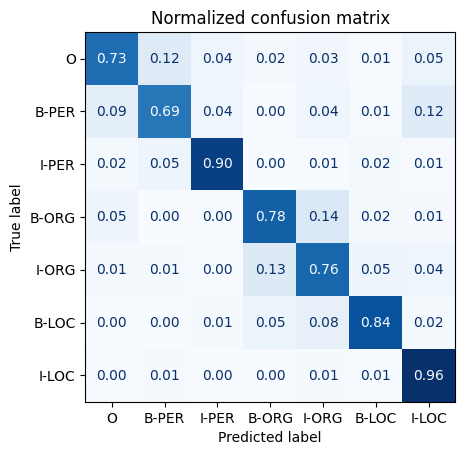

In [51]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names)

In [52]:
# Let's look at the sequences with high loss
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame(
            {"tokens": tokens, "labels": labels, "preds": preds, "losses": losses}
        ).T
    yield df_tmp
    

In [53]:
df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(5)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
tokens,▁In,▁The,▁L,▁Word,▁–,▁Wenn,▁Frauen,▁Frauen,▁lieben,▁'',▁war,▁sie,▁als,▁Student,in,▁zu,▁sehen,▁,.,</s>
labels,O,B-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,O,O,O,O,O,IGN,O,O,O,IGN,IGN
preds,O,B-ORG,I-ORG,I-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.01,3.27,2.55,2.74,3.97,6.36,6.38,6.38,6.36,0.02,0.01,0.01,0.01,0.01,-0.00,0.01,0.01,0.01,-0.00,-0.00


In [54]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-PER,I-PER,I-PER,I-PER,O
losses,0.48,-0.00,-0.00,1.46,1.54,-0.00,1.63,-0.00


## Cross-Lingual Transfer

In [55]:
def get_f1_score(trainer, dataset):
    output = trainer.predict(dataset)
    f1_score = output.metrics["test_f1"]
    return f1_score

In [56]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

100%|██████████| 263/263 [00:39<00:00,  6.64it/s]

F1-score of [de] model on [de] dataset: 0.641


In [59]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-PER,I-LOC,O


In [60]:
# Let's write a function to validate how the model fares on a different language

def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])


In [61]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] mode on [fr] dataset: {f1_scores['de']['fr']:.3f}")

100%|██████████| 96/96 [00:17<00:00,  5.38it/s]

F1-score of [de] mode on [fr] dataset: 0.491


In [63]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] mode on [it] dataset: {f1_scores['de']['it']:.3f}")

100%|██████████| 35/35 [00:02<00:00, 15.20it/s]

F1-score of [de] mode on [it] dataset: 0.477


In [64]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] mode on [fr] dataset: {f1_scores['de']['en']:.3f}")

100%|██████████| 25/25 [00:04<00:00,  6.00it/s]

F1-score of [de] mode on [fr] dataset: 0.417


### When Does Zero-Shot Transfer Make Sense?

In [66]:
# Let's create a funtion to fine-tune our XLM-R on training sets of increasing size
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        tokenizer=xlmr_tokenizer,
    )
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]}
    )

In [67]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Map: 100%|██████████| 4580/4580 [00:00<00:00, 34931.69 examples/s]


In [68]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)

/Users/mmenendezg/Developer/Books/.venv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 30%|███       | 10/33 [00:08<00:13,  1.77it/s]

{'loss': 0.366, 'learning_rate': 3.484848484848485e-05, 'epoch': 0.91}


                                               
 33%|███▎      | 11/33 [00:25<00:21,  1.01it/s]

{'eval_loss': 0.3533759117126465, 'eval_f1': 0.0, 'eval_runtime': 15.3117, 'eval_samples_per_second': 149.559, 'eval_steps_per_second': 6.27, 'epoch': 1.0}


 61%|██████    | 20/33 [00:30<00:10,  1.26it/s]

{'loss': 0.3094, 'learning_rate': 1.9696969696969697e-05, 'epoch': 1.82}


                                               
 67%|██████▋   | 22/33 [00:38<00:12,  1.14s/it]

{'eval_loss': 0.3050245940685272, 'eval_f1': 0.13441215323645972, 'eval_runtime': 5.9189, 'eval_samples_per_second': 386.896, 'eval_steps_per_second': 16.219, 'epoch': 2.0}


 91%|█████████ | 30/33 [00:43<00:02,  1.32it/s]

{'loss': 0.2758, 'learning_rate': 4.5454545454545455e-06, 'epoch': 2.73}


                                               
100%|██████████| 33/33 [00:52<00:00,  1.59s/it]


{'eval_loss': 0.2979810833930969, 'eval_f1': 0.160153937240971, 'eval_runtime': 5.8173, 'eval_samples_per_second': 393.656, 'eval_steps_per_second': 16.503, 'epoch': 3.0}
{'train_runtime': 52.5827, 'train_samples_per_second': 14.263, 'train_steps_per_second': 0.628, 'train_loss': 0.31792962551116943, 'epoch': 3.0}


100%|██████████| 96/96 [00:10<00:00,  9.49it/s]


In [73]:
type(metrics_df)

pandas.core.frame.DataFrame

In [74]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = pd.concat(
        [metrics_df, train_on_subset(panx_fr_encoded, num_samples)], ignore_index=True
    )

/Users/mmenendezg/Developer/Books/.venv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 32%|███▏      | 20/63 [00:12<00:27,  1.58it/s]

{'loss': 0.3561, 'learning_rate': 3.412698412698413e-05, 'epoch': 0.95}


 33%|███▎      | 21/63 [00:20<00:47,  1.12s/it]

{'eval_loss': 0.29545971751213074, 'eval_f1': 0.04493918779633065, 'eval_runtime': 6.0658, 'eval_samples_per_second': 377.526, 'eval_steps_per_second': 15.826, 'epoch': 1.0}


 63%|██████▎   | 40/63 [00:31<00:13,  1.76it/s]

{'loss': 0.2619, 'learning_rate': 1.8253968253968254e-05, 'epoch': 1.9}


 67%|██████▋   | 42/63 [00:40<00:21,  1.02s/it]

{'eval_loss': 0.2303958237171173, 'eval_f1': 0.23202301054650046, 'eval_runtime': 5.9719, 'eval_samples_per_second': 383.46, 'eval_steps_per_second': 16.075, 'epoch': 2.0}


 95%|█████████▌| 60/63 [00:50<00:01,  1.82it/s]

{'loss': 0.2156, 'learning_rate': 2.3809523809523808e-06, 'epoch': 2.86}


100%|██████████| 63/63 [00:59<00:00,  1.06it/s]


{'eval_loss': 0.18678706884384155, 'eval_f1': 0.3563218390804597, 'eval_runtime': 6.0615, 'eval_samples_per_second': 377.792, 'eval_steps_per_second': 15.838, 'epoch': 3.0}
{'train_runtime': 59.4866, 'train_samples_per_second': 25.216, 'train_steps_per_second': 1.059, 'train_loss': 0.27423974067445783, 'epoch': 3.0}


 33%|███▎      | 41/126 [00:24<00:49,  1.70it/s]

{'loss': 0.3148, 'learning_rate': 3.3730158730158734e-05, 'epoch': 0.98}


 33%|███▎      | 42/126 [00:32<01:26,  1.03s/it]

{'eval_loss': 0.20055904984474182, 'eval_f1': 0.3788742182070883, 'eval_runtime': 6.0076, 'eval_samples_per_second': 381.185, 'eval_steps_per_second': 15.98, 'epoch': 1.0}


 65%|██████▌   | 82/126 [00:55<00:27,  1.59it/s]

{'loss': 0.1693, 'learning_rate': 1.746031746031746e-05, 'epoch': 1.95}


 67%|██████▋   | 84/126 [01:02<00:26,  1.57it/s]

{'eval_loss': 0.13163802027702332, 'eval_f1': 0.5746496039000609, 'eval_runtime': 6.0666, 'eval_samples_per_second': 377.48, 'eval_steps_per_second': 15.824, 'epoch': 2.0}


 98%|█████████▊| 123/126 [01:24<00:01,  1.59it/s]

{'loss': 0.1174, 'learning_rate': 1.1904761904761904e-06, 'epoch': 2.93}


100%|██████████| 126/126 [01:33<00:00,  1.35it/s]


{'eval_loss': 0.10837484896183014, 'eval_f1': 0.6784850926672039, 'eval_runtime': 6.034, 'eval_samples_per_second': 379.513, 'eval_steps_per_second': 15.91, 'epoch': 3.0}
{'train_runtime': 93.1186, 'train_samples_per_second': 32.217, 'train_steps_per_second': 1.353, 'train_loss': 0.1978692686746991, 'epoch': 3.0}


 33%|███▎      | 83/252 [00:52<01:46,  1.58it/s]

{'loss': 0.2161, 'learning_rate': 3.353174603174603e-05, 'epoch': 0.99}


 33%|███▎      | 84/252 [01:01<03:06,  1.11s/it]

{'eval_loss': 0.11607041209936142, 'eval_f1': 0.6622623267805349, 'eval_runtime': 6.3725, 'eval_samples_per_second': 359.356, 'eval_steps_per_second': 15.065, 'epoch': 1.0}


 66%|██████▌   | 166/252 [01:47<00:38,  2.23it/s]

{'loss': 0.1034, 'learning_rate': 1.7063492063492063e-05, 'epoch': 1.98}


 67%|██████▋   | 168/252 [01:55<00:44,  1.88it/s]

{'eval_loss': 0.08812423795461655, 'eval_f1': 0.73675604970569, 'eval_runtime': 6.2545, 'eval_samples_per_second': 366.135, 'eval_steps_per_second': 15.349, 'epoch': 2.0}


 99%|█████████▉| 249/252 [02:45<00:01,  1.57it/s]

{'loss': 0.0755, 'learning_rate': 5.952380952380952e-07, 'epoch': 2.96}


100%|██████████| 252/252 [02:53<00:00,  1.45it/s]


{'eval_loss': 0.07982529699802399, 'eval_f1': 0.764454664914586, 'eval_runtime': 6.4629, 'eval_samples_per_second': 354.329, 'eval_steps_per_second': 14.854, 'epoch': 3.0}
{'train_runtime': 173.5447, 'train_samples_per_second': 34.573, 'train_steps_per_second': 1.452, 'train_loss': 0.1312113068406544, 'epoch': 3.0}


 33%|███▎      | 166/501 [01:55<03:26,  1.62it/s]

{'loss': 0.1653, 'learning_rate': 3.343313373253493e-05, 'epoch': 0.99}


 33%|███▎      | 167/501 [02:04<06:36,  1.19s/it]

{'eval_loss': 0.10853596776723862, 'eval_f1': 0.6667760459392944, 'eval_runtime': 6.7614, 'eval_samples_per_second': 338.686, 'eval_steps_per_second': 14.198, 'epoch': 1.0}


 66%|██████▋   | 332/501 [04:00<01:34,  1.79it/s]

{'loss': 0.0793, 'learning_rate': 1.686626746506986e-05, 'epoch': 1.99}


 67%|██████▋   | 334/501 [04:10<03:15,  1.17s/it]

{'eval_loss': 0.0735076516866684, 'eval_f1': 0.7982017982017983, 'eval_runtime': 6.5786, 'eval_samples_per_second': 348.099, 'eval_steps_per_second': 14.593, 'epoch': 2.0}


 99%|█████████▉| 498/501 [06:04<00:01,  1.75it/s]

{'loss': 0.0586, 'learning_rate': 2.9940119760479047e-07, 'epoch': 2.98}


100%|██████████| 501/501 [06:14<00:00,  1.34it/s]


{'eval_loss': 0.06773439049720764, 'eval_f1': 0.8165503489531406, 'eval_runtime': 6.4322, 'eval_samples_per_second': 356.021, 'eval_steps_per_second': 14.925, 'epoch': 3.0}
{'train_runtime': 374.5423, 'train_samples_per_second': 32.039, 'train_steps_per_second': 1.338, 'train_loss': 0.10093944931696514, 'epoch': 3.0}


100%|██████████| 96/96 [00:06<00:00, 14.85it/s]


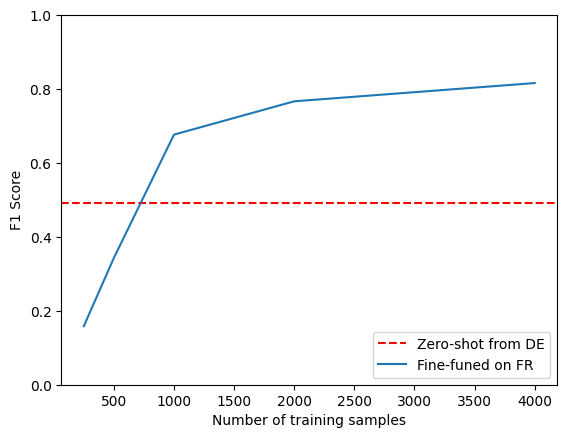

In [76]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from DE", "Fine-funed on FR"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of training samples")
plt.ylabel("F1 Score")
plt.show()

## Fine-Tuning on Multiple languages at Once

In [79]:
def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]
        ).shuffle(seed=SEED)
    return multi_corpus

In [80]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [82]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

In [84]:
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer,
    train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"],
)
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/mmenendezg/xlm-roberta-base-finetuned-panx-de-fr into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/Users/mmenendezg/Developer/Books/.venv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 715/2145 [08:56<18:52,  1.26it/s]

{'loss': 0.143, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}



 33%|███▎      | 715/2145 [09:50<18:52,  1.26it/s]

{'eval_loss': 0.10933879017829895, 'eval_f1': 0.5082643005771269, 'eval_runtime': 53.7347, 'eval_samples_per_second': 159.673, 'eval_steps_per_second': 6.662, 'epoch': 1.0}


 67%|██████▋   | 1430/2145 [18:59<07:59,  1.49it/s] 

{'loss': 0.0797, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 1430/2145 [19:27<07:59,  1.49it/s]

{'eval_loss': 0.06465472280979156, 'eval_f1': 0.6936342346178412, 'eval_runtime': 27.9824, 'eval_samples_per_second': 306.621, 'eval_steps_per_second': 12.794, 'epoch': 2.0}


100%|██████████| 2145/2145 [28:36<00:00,  1.51it/s]  

{'loss': 0.0527, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 2145/2145 [29:05<00:00,  1.23it/s]

{'eval_loss': 0.047461144626140594, 'eval_f1': 0.7899949212798375, 'eval_runtime': 28.4036, 'eval_samples_per_second': 302.074, 'eval_steps_per_second': 12.604, 'epoch': 3.0}
{'train_runtime': 1745.4162, 'train_samples_per_second': 29.494, 'train_steps_per_second': 1.229, 'train_loss': 0.09180304253851618, 'epoch': 3.0}


TrainOutput(global_step=2145, training_loss=0.09180304253851618, metrics={'train_runtime': 1745.4162, 'train_samples_per_second': 29.494, 'train_steps_per_second': 1.229, 'train_loss': 0.09180304253851618, 'epoch': 3.0})

In [87]:
trainer.push_to_hub(commit_message="Training Completed!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/mmenendezg/xlm-roberta-base-finetuned-panx-de-fr
   7fa67e1..5415249  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

'https://huggingface.co/mmenendezg/xlm-roberta-base-finetuned-panx-de-fr/commit/541524936e260a8104d230baf672088d0e62388a'

Let's evaluate the performance of this new model in the rest of languages:

In [88]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-Score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

100%|██████████| 263/263 [00:21<00:00, 12.33it/s]


F1-Score of [de-fr] model on [de] dataset: 0.801


100%|██████████| 96/96 [00:06<00:00, 14.87it/s]


F1-Score of [de-fr] model on [fr] dataset: 0.772


100%|██████████| 35/35 [00:02<00:00, 15.55it/s]


F1-Score of [de-fr] model on [it] dataset: 0.722


100%|██████████| 25/25 [00:01<00:00, 14.72it/s]

F1-Score of [de-fr] model on [en] dataset: 0.619
